In [189]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv2D,
    Conv1D,
    BatchNormalization,
    Activation,
    MaxPooling2D,
    Flatten,
    Dense,
    Input,
    Dropout,
    Concatenate,
    Reshape,
    MaxPooling1D,
    GlobalAveragePooling1D,
    GlobalAveragePooling2D,
)
from tensorflow.keras.regularizers import l2  
from tensorflow.keras.optimizers import Adam

In [190]:
import librosa
import librosa.display
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
import matplotlib.pyplot as plt
import pickle
import joblib
from tensorflow.keras import models, layers
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [191]:
wav_files = 'voice_file/'

In [208]:
# ravdess data
ravdess_directory_list = os.listdir(wav_files)

file_emotion = []
file_path = []
temp = []

for dir in ravdess_directory_list:
    actor_files = os.listdir(os.path.join(wav_files, dir))
    for file in actor_files:
        part = file.split('.')[0]
        part = part.split('-')
        temp.append(part)
        file_path.append(wav_files + dir + '/' + file)
    for i in temp:
        if len(i) >= 3:  
            file_emotion.append(int(i[2]))  
        else:
            file_emotion.append(None)
            


path_df = pd.DataFrame(file_path, columns=['path'])
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])
emotion_df.dropna(inplace=True)

ravdess_df = pd.concat([emotion_df, path_df], axis=1)


ravdess_df.emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df['emotion_num'] = file_emotion


ravdess_df.dropna(inplace=True)
ravdess_df['emotions'].value_counts()

calm        192
happy       192
sad         192
angry       192
fear        192
disgust     192
surprise    192
neutral      96
Name: emotions, dtype: int64

In [207]:
# crema data
crema_directory_list = os.listdir('Crema')

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append('Crema/' + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
crema_df = pd.concat([emotion_df, path_df], axis=1)

crema_df['emotion_num'] = file_emotion
crema_df['emotion_num'].replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5 , 'fear':6, 'disgust':7, 'surprise':8}, inplace=True)

# print(Crema_df.emotions.value_counts())
crema_df['emotions'].value_counts()

disgust    1270
fear       1270
happy      1270
sad        1270
angry      1269
neutral    1086
Name: emotions, dtype: int64

In [206]:
dir_list = os.listdir('Savee')

# parse the filename to get the emotions
emotion=[]
path = []
for i in dir_list:
    if i[-8:-6]=='_a':
        emotion.append('angry')
    elif i[-8:-6]=='_d':
        emotion.append('disgust')
    elif i[-8:-6]=='_f':
        emotion.append('fear')
    elif i[-8:-6]=='_h':
        emotion.append('happy')
    elif i[-8:-6]=='_n':
        emotion.append('neutral')
    elif i[-8:-6]=='sa':
        emotion.append('sad')
    elif i[-8:-6]=='su':
        emotion.append('surprise')
    else:
        emotion.append('unknown') 
    path.append('Savee/' + i)

# Now check out the label count distribution 
savee_df = pd.DataFrame(emotion, columns = ['emotions'])
savee_df = pd.concat([savee_df, pd.DataFrame(path, columns = ['path'])], axis = 1)

savee_df['emotion_num'] = emotion
savee_df['emotion_num'].replace({'neutral':1, 'calm':2, 'happy':3, 'sad':4, 'angry':5 , 'fear':6, 'disgust':7, 'surprise':8}, inplace=True)

savee_df['emotions'].value_counts()

neutral     120
angry        60
disgust      60
fear         60
happy        60
sad          60
surprise     60
Name: emotions, dtype: int64

In [209]:
# df = ravdess_df
df = pd.concat([ravdess_df, crema_df, savee_df], axis=0)
df.reset_index(drop=True, inplace=True)

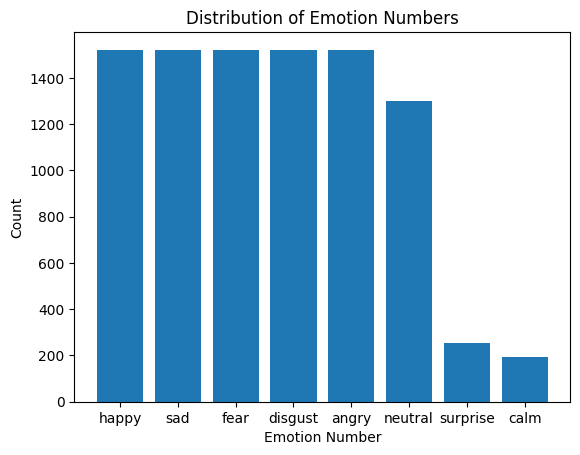

In [210]:
to_plt = df['emotions'].value_counts()

# Plotting
plt.bar(to_plt.index, to_plt.values)

# Adding labels and title
plt.xlabel('Emotion Number')
plt.ylabel('Count')
plt.title('Distribution of Emotion Numbers')

# Display the plot
plt.show()

In [213]:
# Removing surpise 
df = df.drop(df[df['emotions'] == 'surprise'].index)

# Combining 'calm' into 'neutral'
df.loc[df['emotions'] == 'calm', 'emotions'] = 'neutral'

df.loc[df['emotion_num'] == 'neutral', 'emotion_num'] = 1

# Setting the emotion numbers to start with 0 
df['emotion_num'] = df['emotion_num'].astype(int)
df['emotion_num'] = df['emotion_num'].apply(lambda x: x - 1)

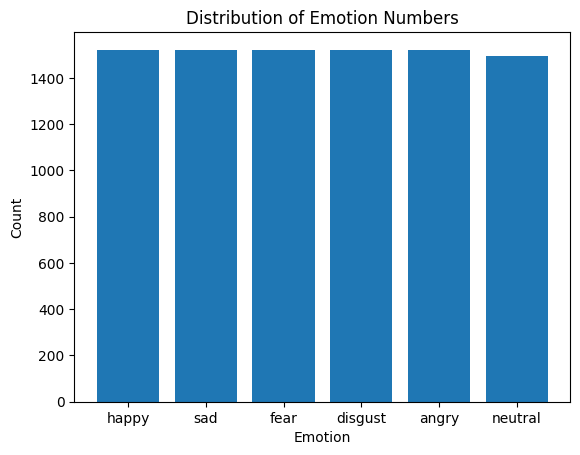

In [214]:
to_plt = df['emotions'].value_counts()
plt.bar(to_plt.index, to_plt.values)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Emotion Numbers')
plt.show()

In [215]:
def padding(array, xx, yy):

    h = array.shape[0]
    w = array.shape[1]
    a = max((xx - h) // 2,0)
    aa = max(0,xx - a - h)
    b = max(0,(yy - w) // 2)
    bb = max(yy - b - w,0)
    return np.pad(array, pad_width=((a, aa), (b, bb)), mode='constant')

In [234]:
# WORKING GET_FEATURES FUNCTION

def generate_features(y_cut):
    
    max_size=640 
    hop_length = 512 
    n_fft = 255
    sr=28000
    
    stft = padding(np.abs(librosa.stft(y_cut, n_fft=n_fft, hop_length= hop_length)), 128, max_size)
#     MFCCs = padding(librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=hop_length,n_mfcc=128),128,max_size)
    MFCCs = padding(librosa.feature.mfcc(y=y_cut),128,max_size)
    spec_centroid = librosa.feature.spectral_centroid(y=y_cut, sr=sr)
    chroma_stft = librosa.feature.chroma_stft(y=y_cut, sr=sr)
    spec_bw = librosa.feature.spectral_bandwidth(y=y_cut, sr=sr)
    
    #Now the padding part
    image = np.array([padding(normalize(spec_bw),1, max_size)]).reshape(1,max_size)
    image = np.append(image,padding(normalize(spec_centroid),1, max_size), axis=0) 
    
#repeat the padded spec_bw,spec_centroid and chroma stft until they are stft and MFCC-sized
    for i in range(0,9):
        image = np.append(image,padding(normalize(spec_bw),1, max_size), axis=0)
        image = np.append(image, padding(normalize(spec_centroid),1, max_size), axis=0)
        image = np.append(image, padding(normalize(chroma_stft),12, max_size), axis=0)
        
    image=np.dstack((image,np.abs(stft)))
    image=np.dstack((image,MFCCs))
    return image

In [219]:
X=df.drop(['emotions', 'emotion_num'],axis=1)
y=df[['emotion_num']]

In [223]:
print(X.shape, y.shape)

(9103, 1) (9103, 1)


In [220]:
total_data = X.shape[0] 

In [221]:
#Split once to get the test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123, stratify=y)

print(X_train.shape,y_train.shape, X_test.shape, y_test.shape)

(6827, 1) (6827, 1) (2276, 1) (2276, 1)


In [222]:
#Split twice to get the validation set
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.4, random_state=123)

print(X_train.shape, X_test.shape, X_val.shape, len(y_train)/total_data, len(y_test)/total_data, len(y_val)/total_data)

(6827, 1) (911, 1) (1365, 1) 0.7499725365264198 0.10007689772602439 0.14995056574755575


In [224]:
def get_features(df_in):   
    
    features=[]     
    labels = [] 
            
    for j in range(len(df_in)):
            
            emotion_num = df_in.iloc[j]['emotion_num']
            filename = df_in.iloc[j]['path']
            
            # Load the file
            y, sr = librosa.load(filename,sr=28000)  
            
            #generate features & output numpy array          
            data = generate_features(y) 
            features.append(data[np.newaxis,...])    
            labels.append(emotion_num)  
            
    output=np.concatenate(features,axis=0)     
    return(np.array(output), labels)

In [227]:
len(crema_df)

7435

In [243]:
savee_features, savee_lables = get_features(savee_df)
np.save('npy_data/data_savee.npy', savee_features)

In [242]:
ravdess_features, ravdess_lables = get_features(ravdess_df)
np.save('npy_data/ravdess_savee.npy', ravdess_features)

In [233]:

# Specify the batch size, data type, and save path
batch_size = 200
dtype = np.float32  # Change data type to float32
save_path = 'npy_data'

# Get the length of the DataFrame
num_samples = len(crema_df)

# Process the DataFrame in smaller chunks
num_batches = (num_samples + batch_size - 1) // batch_size

crema_features_list = []
crema_labels_list = []

for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, num_samples)
    batch_df = crema_df.iloc[start_idx:end_idx]
    
    # Call the get_features function for the current batch
    batch_features, batch_labels = get_features(batch_df)
    
    # Change data type to float32
    batch_features = batch_features.astype(dtype)
    
    # Save the features and labels to .npy files
    np.save(save_path + f'/features_batch{i}.npy', batch_features)
    np.save(save_path + f'/labels_batch{i}.npy', batch_labels)
    
    # Append batch features and labels to lists
    crema_features_list.append(batch_features)
    crema_labels_list.append(batch_labels)

# Combine the features and labels
crema_features = np.concatenate(crema_features_list, axis=0)
crema_labels = np.concatenate(crema_labels_list, axis=0)

# Save the combined features and labels to .npy files
np.save(save_path + '/crema_features.npy', crema_features)
np.save(save_path + '/crema_labels.npy', crema_labels)


MemoryError: Unable to allocate 7.45 GiB for an array with shape (7435, 128, 700, 3) and data type float32

In [238]:
# Collected as much as I could - NOT ALL DATA

# Combine the features and labels
crema_features = np.concatenate(crema_features_list, axis=0)
crema_labels = np.concatenate(crema_labels_list, axis=0)

# Save the combined features and labels to .npy files
np.save(save_path + '/crema_features.npy', crema_features)
np.save(save_path + '/crema_labels.npy', crema_labels)

In [244]:
# Directory where the .npy files are stored
directory = 'npy_data'

# List all .npy files in the directory
npy_files = [file for file in os.listdir(directory) if file.endswith('.npy')]

# Load each .npy file and concatenate them
all_features = []
all_labels = []

for file in npy_files:
    if 'features' in file:
        features = np.load(os.path.join(directory, file))
        all_features.append(features)
    elif 'labels' in file:
        labels = np.load(os.path.join(directory, file))
        all_labels.append(labels)

# Concatenate all features and labels
all_features = np.concatenate(all_features, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Save the concatenated features and labels to .npy files
np.save('npy_data/combined_features.npy', all_features)
np.save('npy_data/combined_labels.npy', all_labels)


In [248]:
print(all_features.shape, all_labels.shape)

(7435, 128, 700, 3) (7435,)


In [1]:
# Trying to load combined npy file fails due to lack of space 

# combined_features = np.load('npy_data/combined_features.npy')

In [225]:
#use get_features to calculate and store the features
test_features, test_labels = get_features(pd.concat([X_test,y_test],axis=1))
train_features, train_labels = get_features(pd.concat([X_train,y_train],axis=1))

MemoryError: Unable to allocate 13.7 GiB for an array with shape (6827, 128, 700, 3) and data type float64

In [127]:
# Issue with labels extraction - SOLVED
print('labels:',set(test_labels), set(train_labels))
print('features:',train_features.shape, test_features.shape)

labels: {0, 1, 2, 3, 4, 5, 6, 7} {0, 1, 2, 3, 4, 5, 6, 7}
features: (1080, 128, 700, 3) (144, 128, 700, 3)


In [112]:
# Normalizing & StdScaler

# train_features = np.array((train_features-np.min(train_features))/(np.max(train_features)-np.min(train_features)))
# test_features = np.array((test_features-np.min(test_features))/(np.max(test_features)-np.min(test_features)))
# train_features = train_features/np.std(train_features)
# test_features = test_features/np.std(test_features)
# y_train = np.array(y_train)
# y_test = np.array(y_test)

In [142]:
def get_2d_encoder(input_shape, batch_norm, conv_channels, dropout_prob, pooling, activation, kernel_size, reg_factor):
    """
    Build a 2D convolutional encoder for image-like data (e.g., spectrograms) with regularization.
    
    Parameters:
    - reg_factor (float): L2 regularization factor.
    """
    model = Sequential()
    model.add(Input(shape=input_shape))
    for layer_conv_ch in conv_channels:
        stride = 1 if pooling else 2
        model.add(Conv2D(layer_conv_ch, kernel_size, padding='same', strides=stride, kernel_regularizer=l2(reg_factor)))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(Activation(activation))
        if pooling:
            model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(dropout_prob))
    model.add(GlobalAveragePooling2D())
    return model


In [143]:
def get_model(input_shape, batch_norm, conv_channels, dense_widths, dropout_prob, pooling, activation, num_classes, reg_factor):
    """
    Constructs a neural network model for classifying images with regularization.
    
    Parameters:
    - reg_factor (float): L2 regularization factor.
    """
    image_spectograms = Input(shape=input_shape)
    embeddings = get_2d_encoder(
        input_shape=input_shape,
        batch_norm=batch_norm,
        conv_channels=conv_channels,
        dropout_prob=dropout_prob,
        pooling=pooling,
        activation=activation,
        kernel_size=3,
        reg_factor=reg_factor,
    )(image_spectograms)
    x = embeddings
    for units in dense_widths:
        x = Dense(units, activation=activation, kernel_regularizer=l2(reg_factor))(x)
        x = Dropout(dropout_prob)(x)
    output_layer = Dense(num_classes, activation='softmax', kernel_regularizer=l2(reg_factor))(x)
    model = Model(inputs=image_spectograms, outputs=output_layer)
    return model

In [185]:
# conv_channels = [32, 64, 64]

# dense_widths = [64, 32, 24]

model = get_model(
        input_shape=(128,640,3),
        batch_norm=False,  # set to True only if you use batch_size above 32
        conv_channels=[32, 64, 64], # every element is the number of channels in 1 convolutional layer. the list's length determines the number of conv layers that will be applied. 
        dense_widths=[64, 32, 24],  # every element is the number of neurons in 1 dense layer. the list's length determines the number of dense layers that will be applied. 
        dropout_prob=0.2,  # probability that a neuron will be shut down for one step of training. 
        pooling=False,  # determines whether the convolution shrinks the tensor, or a pooling layer is added after the convolution to do so. You can start with True.
        activation='relu', # the type of non-linear function that is applied after each convolution.
        num_classes=8,
        reg_factor=1e-5
    )

In [174]:
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 128, 700, 3)]     0         
                                                                 
 sequential_17 (Sequential)  (None, 64)                56320     
                                                                 
 dense_50 (Dense)            (None, 64)                4160      
                                                                 
 dropout_49 (Dropout)        (None, 64)                0         
                                                                 
 dense_51 (Dense)            (None, 32)                2080      
                                                                 
 dropout_50 (Dropout)        (None, 32)                0         
                                                                 
 dense_52 (Dense)            (None, 24)                792 

In [132]:
input_shape=(128,700,3)
CNNmodel = models.Sequential()
CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.MaxPooling2D((2, 2)))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
CNNmodel.add(layers.Flatten())
CNNmodel.add(layers.Dense(64, activation='relu'))
CNNmodel.add(layers.Dropout(0.2))
CNNmodel.add(layers.Dense(32, activation='relu'))
CNNmodel.add(layers.Dense(24, activation='softmax'))

In [139]:
CNNmodel.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 126, 698, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 63, 349, 32)       0         
 ng2D)                                                           
                                                                 
 dropout_27 (Dropout)        (None, 63, 349, 32)       0         
                                                                 
 conv2d_41 (Conv2D)          (None, 61, 347, 64)       18496     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 30, 173, 64)       0         
 ng2D)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 30, 173, 64)     

In [186]:
# my_model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])
# CNNmodel.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

model.compile(
    optimizer=Adam(learning_rate=1e-2),  # Adam optimizer with LR of 0.001
    loss='sparse_categorical_crossentropy',  # Loss function for integer-type labels
    metrics=['accuracy']  # Track accuracy during training
)

In [ ]:
### history = my_model.fit(train_features, y_train, epochs=10, validation_data= (test_features, y_test))
# history = CNNmodel.fit(train_features, y_train, epochs=20, validation_data= (test_features, y_test))
history = model.fit(train_features, y_train, epochs=200, validation_data= (test_features, y_test), batch_size=32)

In [ ]:
# input_shape=(128,700,3)
# CNNmodel = models.Sequential()
# CNNmodel.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
# CNNmodel.add(layers.MaxPooling2D((2, 2)))
# CNNmodel.add(layers.Dropout(0.2))
# CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
# CNNmodel.add(layers.MaxPooling2D((2, 2)))
# CNNmodel.add(layers.Dropout(0.2))
# CNNmodel.add(layers.Conv2D(64, (3, 3), activation='relu'))
# CNNmodel.add(layers.Flatten())
# CNNmodel.add(layers.Dense(64, activation='relu'))
# CNNmodel.add(layers.Dropout(0.2))
# CNNmodel.add(layers.Dense(32, activation='relu'))
# CNNmodel.add(layers.Dense(24, activation='softmax'))

In [172]:
print(train_features.shape, y_train.shape, test_features.shape, y_test.shape)

(1080, 128, 700, 3) (1080, 1) (144, 128, 700, 3) (144, 1)


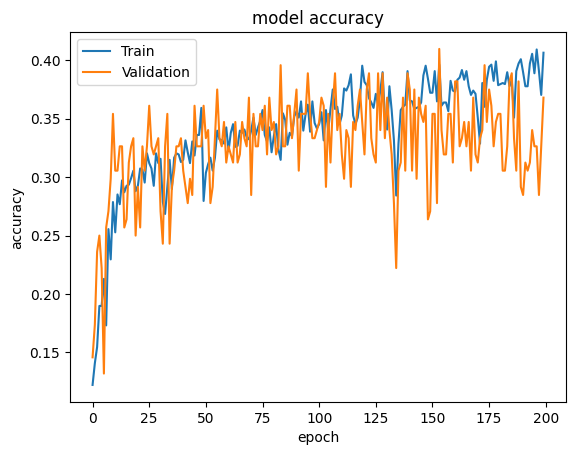

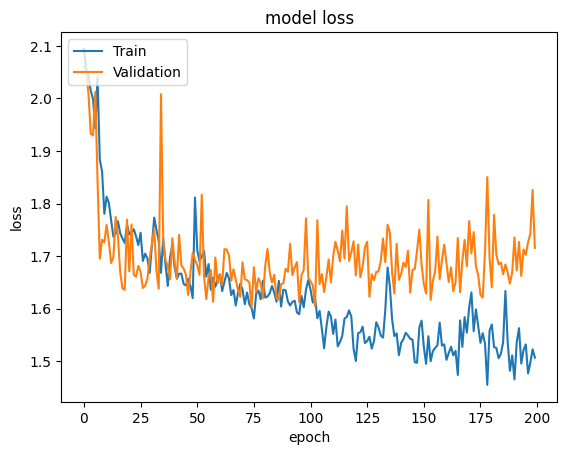

In [188]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Training model 1/3 with hyperparameters: {'conv_channels': [32, 64, 64], 'dense_widths': [64, 32, 24], 'dropout_prob': 0.2, 'pooling': True, 'reg_factor': 1e-05}
Epoch 1/15
34/34 [==============================] - 73s 2s/step - loss: 2.2269 - accuracy: 0.1287 - val_loss: 2.0593 - val_accuracy: 0.1597
Epoch 2/15
34/34 [==============================] - 68s 2s/step - loss: 2.0647 - accuracy: 0.1509 - val_loss: 2.0563 - val_accuracy: 0.1389
Epoch 3/15
34/34 [==============================] - 67s 2s/step - loss: 2.0673 - accuracy: 0.1370 - val_loss: 2.0520 - val_accuracy: 0.1389
Epoch 4/15
34/34 [==============================] - 67s 2s/step - loss: 2.0651 - accuracy: 0.1380 - val_loss: 2.0483 - val_accuracy: 0.1250
Epoch 5/15
34/34 [==============================] - 67s 2s/step - loss: 2.0712 - accuracy: 0.1315 - val_loss: 2.0546 - val_accuracy: 0.1389
Epoch 6/15
34/34 [==============================] - 68s 2s/step - loss: 2.0458 - accuracy: 0.1361 - val_loss: 1.9882 - val_accuracy: 0.243

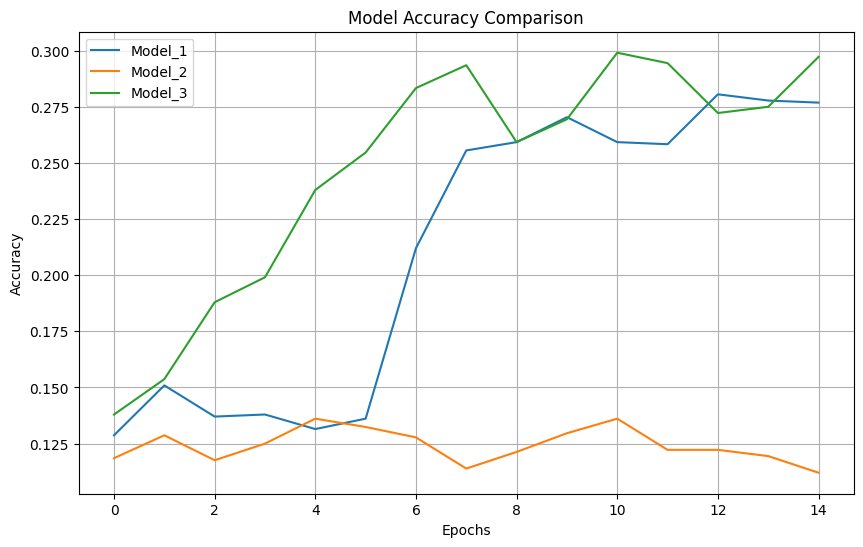

In [184]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

# Define a list of dictionaries containing different sets of hyperparameters
hyperparameters_list = [
    {"conv_channels": [32, 64, 64], "dense_widths": [64, 32, 24], "dropout_prob": 0.2, "pooling": True, "reg_factor": 1e-5},
    {"conv_channels": [32, 64, 64], "dense_widths": [64, 32, 24], "dropout_prob": 0.3, "pooling": True, "reg_factor": 1e-5},
    {"conv_channels": [32, 64, 64], "dense_widths": [64, 32, 24], "dropout_prob": 0.2, "pooling": False, "reg_factor": 1e-5},
    # Add more hyperparameter combinations as needed
]

# Define an empty dictionary to store the accuracy history of each model
history_dict = {}

# Iterate over each set of hyperparameters
for idx, hyperparams in enumerate(hyperparameters_list):
    print(f"Training model {idx + 1}/{len(hyperparameters_list)} with hyperparameters: {hyperparams}")
    
    # Create the model with the current set of hyperparameters
    model = get_model(input_shape=(128, 700, 3), batch_norm=False, activation='relu', num_classes=8, **hyperparams)
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-2), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model and store the history
    history = model.fit(train_features, y_train, epochs=15, validation_data=(test_features, y_test), batch_size=32)
    
    # Store the accuracy history in the dictionary
    history_dict[f"Model_{idx + 1}"] = history.history['accuracy']

# Plot the accuracy history of each model
plt.figure(figsize=(10, 6))
for model_name, acc_history in history_dict.items():
    plt.plot(acc_history, label=model_name)

plt.title('Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### TESTING AREA

In [ ]:
train_features[0][0][350]

In [56]:
# No issue with file load
y, sr = librosa.load(df['path'][1],sr=28000)  

# Issue with feature extraction - possibly due to padding
# data = generate_features(y) 
# data

max_size=10
hop_length = 512 
n_fft = 255
sr=28000

# MFCCs = padding(librosa.feature.mfcc(y=y, n_fft=n_fft, hop_length=hop_length,n_mfcc=128),128,max_size)
# stft_ = np.abs(librosa.stft(y, n_fft=n_fft, hop_length= hop_length))
# chroma = librosa.feature.chroma_stft(y=y, sr=sr)
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)

chroma_stft.shape

(12, 183)

In [ ]:
features=[]

features.append(MFCCs[np.newaxis,...])    
features.append(stft_[np.newaxis,...])    
# features.append(chroma[np.newaxis,...])    

            
            
output=np.concatenate(features,axis=0)     

In [ ]:
# print(chroma[0])
print(stft_.shape, MFCCs.shape, chroma.shape)
